# Demo Notebook on how to load the transfer core and train a model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset

# Build the dataloaders

The dataloaders object is a dictionary of 3 dictionaries: train, validation and test. Each of them contains the respective data from all datasets combined that were specified in paths. Here we only provide one dataset. While the responses are normalized, we exclude the input images from normalization. The following config was used in the paper (all arguments not in the config have the default value of the function). 

In [5]:
from lurz2020.datasets.mouse_loaders import static_loaders

#paths = ['original_code/lurz2020/static20457-5-9-preproc0']
paths = ['data/Lurz2020/static20457-5-9-preproc0']

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': 1, 
                  'cuda': True,
                  'normalize': True, 
                  'exclude': "images"}

dataloaders = static_loaders(**dataset_config)
#dat = FileTreeDataset('original_code/lurz2020/static20457-5-9-preproc0', "images", "responses")
dat = FileTreeDataset('data/Lurz2020/static20457-5-9-preproc0', "images", "responses")

### Look at the data

In [32]:
tier = 'test'
dataset_name = '20457-5-9-0'

images, responses = [], []
for x, y in dataloaders[tier][dataset_name]:
    images.append(x.squeeze().cpu().data.numpy())
    responses.append(y.squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "test" set of dataset "20457-5-9-0" contains the responses of 5335 neurons to 999 images


In [57]:
#x=np.load('./data/Lurz2020/static20457-5-9-preproc0/meta/statistics/responses/stimulus_frame/std.npy')
#x
#dataloaders2 = dataloaders["train"]
#next(iter(list(dataloaders2.values())[0]))._fields
#session_shape_dict[dataset_name]['images']

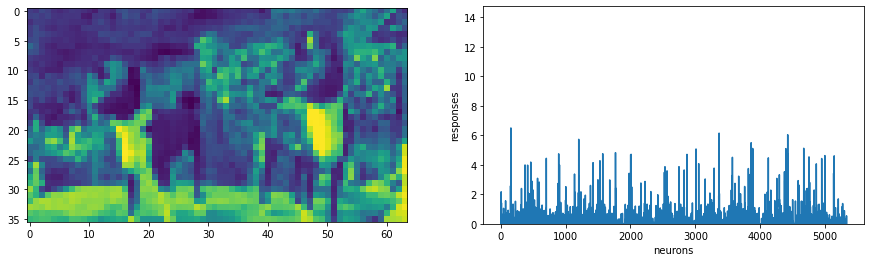

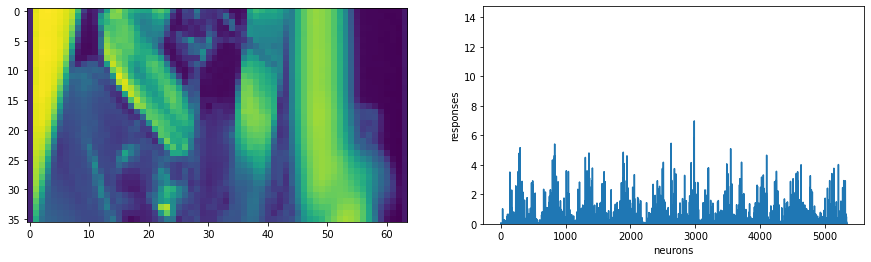

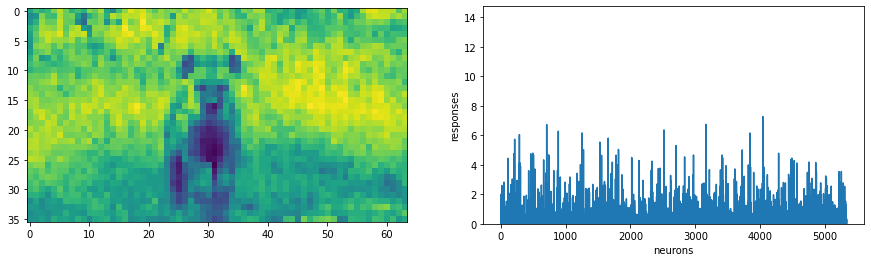

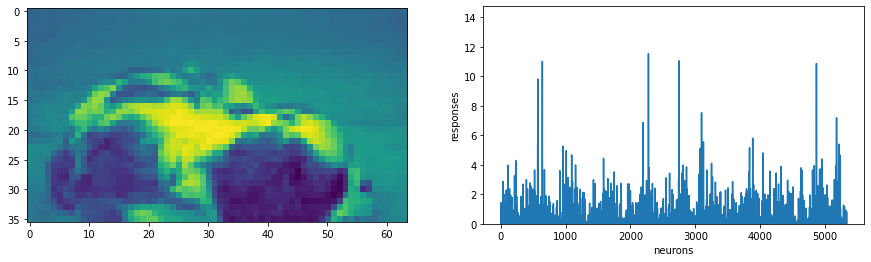

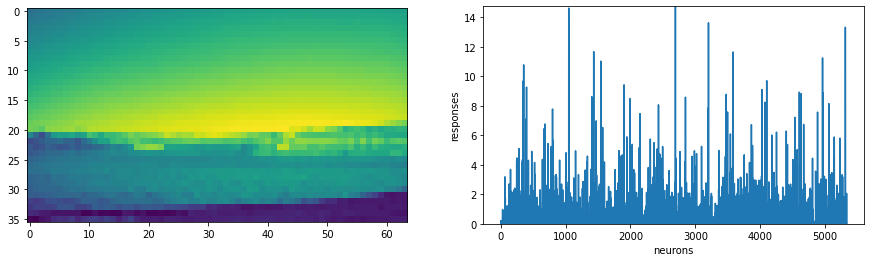

In [11]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i])
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

# Build the model

If you want to load the transfer core later on, the arguments in the model config that concern the architecture of the model can not be changed. The following config was used in the paper (all arguments not in the config have the default value of the function).

In [12]:
from lurz2020.models.models import se2d_fullgaussian2d

model_config = {'init_mu_range': 0.55,
                'init_sigma': 0.4,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': {'type': 'cortex',
                                        'input_dimensions': 2,
                                        'hidden_layers': 0,
                                        'hidden_features': 0,
                                        'final_tanh': False},
                'gamma_readout': 2.439}

model = se2d_fullgaussian2d(**model_config, dataloaders=dataloaders, seed=1)

## Load the weights of the transfer core

This will load the weights of the transfer core onto the model that you built above. The argument `strict=False` ensures that only matching keys are loaded. The readout keys are thus discarded.

In [15]:
transfer_model = torch.load('original_code/Lurz_2020_code/notebooks/models/transfer_model.pth.tar') 
model.load_state_dict(transfer_model, strict=False)

_IncompatibleKeys(missing_keys=['readout.20457-5-9-0.sigma', 'readout.20457-5-9-0._features', 'readout.20457-5-9-0.bias', 'readout.20457-5-9-0.source_grid', 'readout.20457-5-9-0.mu_transform.0.weight', 'readout.20457-5-9-0.mu_transform.0.bias'], unexpected_keys=['readout.22564-2-12-0.sigma', 'readout.22564-2-12-0._features', 'readout.22564-2-12-0.bias', 'readout.22564-2-12-0.source_grid', 'readout.22564-2-12-0.mu_transform.0.weight', 'readout.22564-2-12-0.mu_transform.0.bias', 'readout.22564-2-13-0.sigma', 'readout.22564-2-13-0._features', 'readout.22564-2-13-0.bias', 'readout.22564-2-13-0.source_grid', 'readout.22564-2-13-0.mu_transform.0.weight', 'readout.22564-2-13-0.mu_transform.0.bias', 'readout.22564-3-8-0.sigma', 'readout.22564-3-8-0._features', 'readout.22564-3-8-0.bias', 'readout.22564-3-8-0.source_grid', 'readout.22564-3-8-0.mu_transform.0.weight', 'readout.22564-3-8-0.mu_transform.0.bias', 'readout.22564-3-12-0.sigma', 'readout.22564-3-12-0._features', 'readout.22564-3-12-0.

# Build the trainer

In [16]:
from lurz2020.training.trainers import standard_trainer as trainer

# If you want to allow fine tuning of the core, set detach_core to False
detach_core=True
if detach_core:
    print('Core is fixed and will not be fine-tuned')
else:
    print('Core will be fine-tuned')

trainer_config = {'track_training': True,
                  'detach_core': detach_core}

Core is fixed and will not be fine-tuned


# Run training

In [17]:
score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=1, **trainer_config)

correlation -0.00083923974
poisson_loss 3445073.0


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 23.21it/s]


[001|00/05] ---> 0.20053380727767944
correlation 0.2005338
poisson_loss 1811638.6


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 22.86it/s]


[002|00/05] ---> 0.24912585318088531
correlation 0.24912585
poisson_loss 1744518.5


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.83it/s]


[003|00/05] ---> 0.28310322761535645
correlation 0.28310323
poisson_loss 1698222.8


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 22.08it/s]


[004|00/05] ---> 0.30215194821357727
correlation 0.30215195
poisson_loss 1667882.0


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 23.16it/s]


[005|00/05] ---> 0.31185322999954224
correlation 0.31185323
poisson_loss 1652855.0


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.75it/s]


[006|00/05] ---> 0.3154659867286682
correlation 0.315466
poisson_loss 1646226.8


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.67it/s]


[007|00/05] ---> 0.3205491602420807
correlation 0.32054916
poisson_loss 1640162.1


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.63it/s]


[008|00/05] ---> 0.3220966160297394
correlation 0.32209662
poisson_loss 1638156.2


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.67it/s]


[009|00/05] ---> 0.3229318857192993
correlation 0.3229319
poisson_loss 1635760.8


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.43it/s]


[010|01/05] -/-> 0.32268133759498596
correlation 0.32268134
poisson_loss 1636208.2


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.70it/s]


[011|01/05] ---> 0.32408106327056885
correlation 0.32408106
poisson_loss 1634122.0


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.20it/s]


[012|00/05] ---> 0.3244241178035736
correlation 0.32442412
poisson_loss 1634828.5


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.05it/s]


[013|00/05] ---> 0.3250419497489929
correlation 0.32504195
poisson_loss 1633132.8


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.17it/s]


[014|01/05] -/-> 0.32348862290382385
correlation 0.32348862
poisson_loss 1635945.5


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.86it/s]


[015|02/05] -/-> 0.32351163029670715
correlation 0.32351163
poisson_loss 1635764.2


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.36it/s]


[016|03/05] -/-> 0.3239840865135193
correlation 0.3239841
poisson_loss 1634131.2


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 23.23it/s]


[017|04/05] -/-> 0.3237698972225189
correlation 0.3237699
poisson_loss 1634826.8


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.55it/s]


[018|05/05] -/-> 0.3247181177139282
Restoring best model after lr decay! 0.324718 ---> 0.325042
correlation 0.32504195
poisson_loss 1633132.8


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.36it/s]


Epoch    19: reducing learning rate of group 0 to 1.5000e-03.
[019|01/05] -/-> 0.3236595392227173
correlation 0.32365954
poisson_loss 1634698.8


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.41it/s]


[020|01/05] ---> 0.32523393630981445
correlation 0.32523394
poisson_loss 1631482.1


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.57it/s]


[021|01/05] -/-> 0.32456669211387634
correlation 0.3245667
poisson_loss 1633372.8


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.69it/s]


[022|01/05] ---> 0.3252577781677246
correlation 0.32525778
poisson_loss 1632270.5


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.49it/s]


[023|00/05] ---> 0.3257191777229309
correlation 0.32571918
poisson_loss 1630543.2


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.56it/s]


[024|01/05] -/-> 0.32546114921569824
correlation 0.32546115
poisson_loss 1630695.6


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.64it/s]


[025|02/05] -/-> 0.32560136914253235
correlation 0.32560137
poisson_loss 1630180.5


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.29it/s]


[026|02/05] ---> 0.32591506838798523
correlation 0.32591507
poisson_loss 1630440.2


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.70it/s]


[027|01/05] -/-> 0.3252617120742798
correlation 0.3252617
poisson_loss 1631115.9


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.41it/s]


[028|02/05] -/-> 0.32546332478523254
correlation 0.32546332
poisson_loss 1630458.9


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.51it/s]


[029|03/05] -/-> 0.32438889145851135
correlation 0.3243889
poisson_loss 1632611.5


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.31it/s]


[030|04/05] -/-> 0.3258495628833771
correlation 0.32584956
poisson_loss 1630405.5


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.33it/s]


[031|05/05] -/-> 0.3250479996204376
Restoring best model after lr decay! 0.325048 ---> 0.325915
correlation 0.32591507
poisson_loss 1630440.2


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.34it/s]


Epoch    32: reducing learning rate of group 0 to 4.5000e-04.
[032|01/05] -/-> 0.32499662041664124
correlation 0.32499662
poisson_loss 1631995.9


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.25it/s]


[033|02/05] -/-> 0.32553309202194214
correlation 0.3255331
poisson_loss 1631385.1


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.31it/s]


[034|03/05] -/-> 0.32541680335998535
correlation 0.3254168
poisson_loss 1631055.5


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.58it/s]


[035|04/05] -/-> 0.3254639804363251
correlation 0.32546398
poisson_loss 1630692.6


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.49it/s]


[036|05/05] -/-> 0.32518330216407776
Restoring best model after lr decay! 0.325183 ---> 0.325915
Restoring best model! 0.325915 ---> 0.325915


# Analyze the trained model

### Predict neural responses to an image (here from the train set)

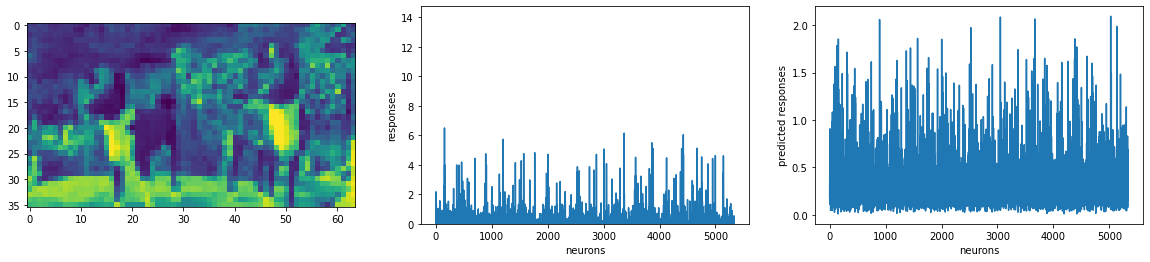

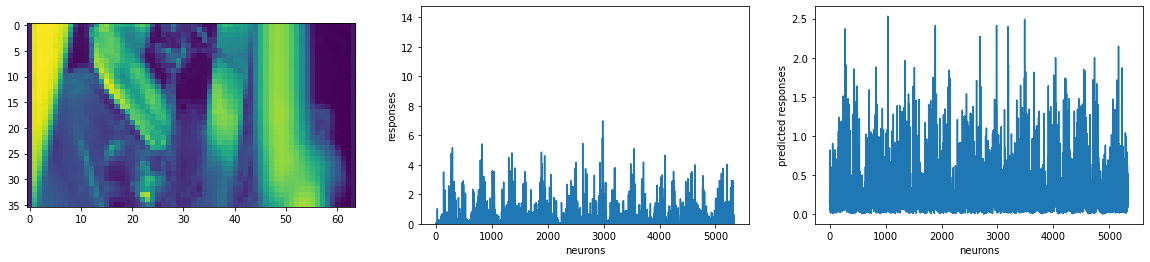

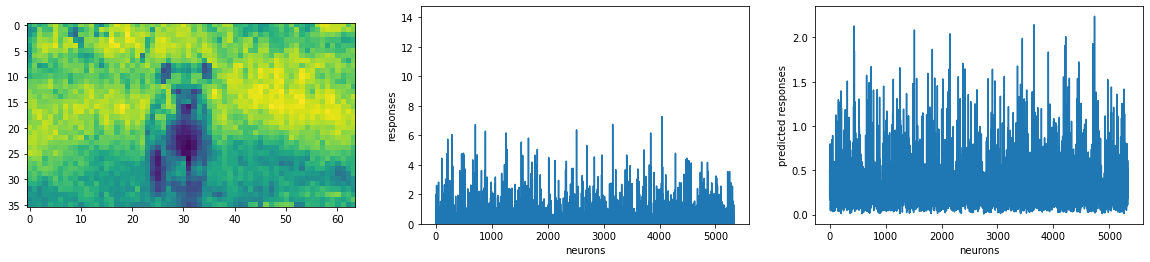

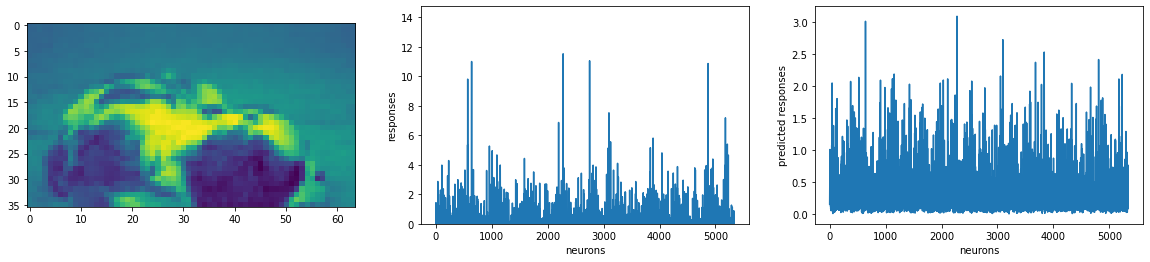

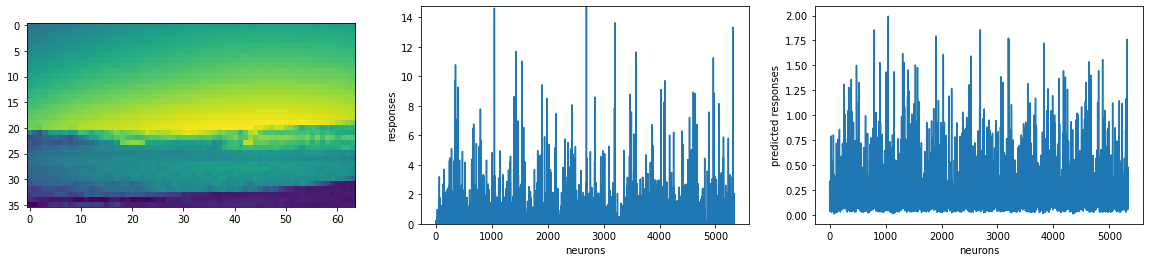

In [18]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    input_image = images[i]
    predicted_response = model(torch.from_numpy(input_image).view(1,1,36,64).cuda())
    predicted_response = predicted_response.squeeze().cpu().data.numpy()
    
    fig, axs = plt.subplots(1, 3, figsize=(20,4))
    axs[0].imshow(input_image)
    axs[1].plot(responses[i])
    axs[2].plot(predicted_response)
    axs[1].set_xlabel('neurons')
    axs[2].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[2].set_ylabel('predicted responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

### Get the performance of your model

In [19]:
from lurz2020.utility.measures import get_correlations, get_fraction_oracles

train_correlation = get_correlations(model, dataloaders["train"], device='cuda', as_dict=False, per_neuron=False)
validation_correlation = get_correlations(model, dataloaders["validation"], device='cuda', as_dict=False, per_neuron=False)
test_correlation = get_correlations(model, dataloaders["test"], device='cuda', as_dict=False, per_neuron=False)

# Fraction Oracle can only be computed on the test set. It requires the dataloader to give out batches of repeats of images. 
# This is achieved by building a dataloader with the argument "return_test_sampler=True"
oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
fraction_oracle = get_fraction_oracles(model=model, dataloaders=oracle_dataloader, device='cuda')[0]

print('-----------------------------------------')
print('Correlation (train set):      {0:.3f}'.format(train_correlation))
print('Correlation (validation set): {0:.3f}'.format(validation_correlation))
print('Correlation (test set):       {0:.3f}'.format(test_correlation))
print('-----------------------------------------')
print('Fraction oracle (test set):   {0:.3f}'.format(fraction_oracle))

Returning only test sampler with repeats...


d:\inception_loop\original_code\lurz_2020_code\lurz2020\utility\measures.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(repeated_inputs), np.array(repeated_outputs)


-----------------------------------------
Correlation (train set):      0.385
Correlation (validation set): 0.326
Correlation (test set):       0.325
-----------------------------------------
Fraction oracle (test set):   0.837


d:\inception_loop\original_code\lurz_2020_code\lurz2020\utility\measures.py:239: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  oracle_performance, _, _, _ = np.linalg.lstsq(np.hstack(oracles)[:, np.newaxis], np.hstack(test_correlation))


# MEI generation

In [113]:
 """
    # parameters for the MEI generation
    ---
    iter_n              : int   # number of iterations to run
    start_sigma         : float # starting sigma value
    end_sigma           : float # ending sigma value
    start_step_size     : float # starting step size
    end_step_size       : float # ending step size
    precond             : float # strength of gradient preconditioning filter falloff
    step_gain           : float # scaling of gradient steps
    jitter              : int   #size of translational jittering
    blur                : bool  # whether to apply bluring or not
    norm                : float # norm adjustment after step, negative to turn off
    train_norm          : float # norm adjustment during step, negative to turn off
"""
MEIParameter = {
       
    'iter_n' : 1000,
    'start_sigma' : 1.5,     
    'end_sigma'   : 0.01,       
    'start_step_size' : 3.0,    
    'end_step_size' : 0.125,      
    'precond' : 0.1,           
    'step_gain' : 0.1,          
    'jitter' : 0,           
    'blur' : True,               
    'norm' :  -1,              
    'train_norm' : -1
}
#1000, 1.5, 0.01, 3.0, 0.125, 0.1, 0.1, 0, False, -1, 11.0)
MEIS = {}

In [157]:
TargetUnit=2

In [158]:
#def MEI(model,MEIParameter,TargetUnit):
"""
    -> TargetModel
    -> MEIParameter
    -> TargetUnit
    ---
    n_seeds             : int       # number of distinct seeded models used
    mei                 : longblob  # most exciting images
    activation          : float     # activation at the MEI
    monotonic           : bool      # does activity increase monotonically with contrast
    max_contrast        : float     # contrast at which maximum activity is achived
    max_activation      : float     # activation at the maximum contrast
    sat_contrast        : float     # contrast at which image would start saturating
    img_mean            : float     # mean luminance of the image
    lim_contrast        : float     # max reachable contrast without clipping
"""

neuron_id = TargetUnit

print('Working on neuron_id={}'.format(neuron_id))

# get input statistics
dataset, img_shape, bias, mu_beh, mu_eye, scale = prepare_data(tier=tier,dataset_name=dataset_name,dat=dat)
print('Working with images with mu={}, sigma={}'.format(bias, scale))

#model = model[:, key['neuron_id']]

params = MEIParameter
blur = bool(params['blur'])
jitter = int(params['jitter'])
precond = float(params['precond'])
step_gain = float(params['step_gain'])
norm = float(params['norm'])
train_norm = float(params['train_norm'])

octaves = [
            {
                'iter_n': int(params['iter_n']),
                'start_sigma': float(params['start_sigma']),
                'end_sigma': float(params['end_sigma']),
                'start_step_size': float(params['start_step_size']),
                'end_step_size': float(params['end_step_size']),
            },
        ]

# prepare initial image
channels, original_h, original_w = img_shape[-3:]
# the background color of the initial image
background_color = np.float32([128] * channels)
# generate initial random image
gen_image = np.random.normal(background_color, 8, (original_h, original_w, channels))
gen_image = np.clip(gen_image, 0, 255)

# generate class visualization via octavewise gradient ascent
gen_image = deepdraw(model, neuron_id, gen_image, octaves, clip=True,
                             random_crop=False, blur=blur, jitter=jitter,
                             precond=precond, step_gain=step_gain,
                             bias=bias, scale=scale, norm=norm, train_norm=train_norm)

mei = gen_image.squeeze()

with torch.no_grad():
    img = torch.Tensor(process(gen_image, mu=bias, sigma=scale)[None, ...]).to('cuda')
    activation = model(img)[:,neuron_id].data.cpu().numpy()[0]

cont, vals, lim_contrast = contrast_tuning(model,neuron_id, mei, bias, scale)

MEIS[str(neuron_id)] = {
    'neuron_id' : neuron_id,
    'n_seeds' : 1,
    'mei' : mei,     
    'activation'   : activation,       
    'monotonic' : bool(np.all(np.diff(vals) >= 0)),    
    'max_activation' : np.max(vals),      
    'max_contrast' : cont[np.argmax(vals)],           
    'sat_contrast' : np.max(cont),          
    'img_mean' : mei.mean(),           
    'lim_contrast' : lim_contrast,
}

#return MEIS

Working on neuron_id=2
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 10 in octave 0
finished step 20 in octave 0
finished step 30 in octave 0
finished step 40 in octave 0
finished step 50 in octave 0
finished step 60 in octave 0
finished step 70 in octave 0
finished step 80 in octave 0
finished step 90 in octave 0
finished step 100 in octave 0
finished step 110 in octave 0
finished step 120 in octave 0
finished step 130 in octave 0
finished step 140 in octave 0
finished step 150 in octave 0
finished step 160 in octave 0
finished step 170 in octave 0
finished step 180 in octave 0
finished step 190 in octave 0
finished step 200 in octave 0
finished step 210 in octave 0
finished step 220 in octave 0
finished step 230 in octave 0
finished step 240 in octave 0
finished step 250 in octave 0
finished step 260 in octave 0
finished step 270 in octave 0
finished step 280 in octave 0
finished

  0%|                                                                                                                       | 0/1000 [00:00<?, ?it/s]

finished step 980 in octave 0
finished step 990 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 473.22it/s]


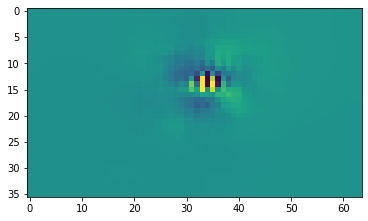

In [159]:
plt.imshow(MEIS[str(TargetUnit)]['mei'])

In [160]:
MEIS

{'0': {'neuron_id': 0,
  'n_seeds': 1,
  'mei': array([[127.3625342 , 127.36725048, 127.37680471, ..., 130.01024285,
          129.99429794, 129.98625648],
         [127.35100955, 127.3560273 , 127.36576858, ..., 130.0056773 ,
          129.98988676, 129.98211952],
         [127.33408216, 127.3390545 , 127.34841442, ..., 130.00477291,
          129.98854288, 129.9806467 ],
         ...,
         [127.40871814, 127.41231029, 127.41922399, ..., 129.99910502,
          129.98388108, 129.97640804],
         [127.4204698 , 127.42403107, 127.43116269, ..., 130.00358703,
          129.98719174, 129.97907582],
         [127.42461584, 127.42835145, 127.43579362, ..., 130.0036397 ,
          129.98682671, 129.97851103]]),
  'activation': 0.21034783,
  'monotonic': True,
  'max_activation': 0.21034783,
  'max_contrast': 12.522405867270521,
  'sat_contrast': 12.522405867270521,
  'img_mean': 130.9263894733674,
  'lim_contrast': 15.685564390442678},
 '1': {'neuron_id': 1,
  'n_seeds': 1,
  'mei': a

In [125]:
from scipy import ndimage
from scipy import signal
from tqdm import tqdm
from nnfabrik.utility.nn_helpers import get_dims_for_loader_dict

def prepare_data(tier,dataset_name,dat):
    trainset = dataloaders[tier]
    img_shape = get_dims_for_loader_dict(trainset)[dataset_name]['images']
    mu = dat.statistics['images']['all']['mean'].item()
    s = dat.statistics['images']['all']['std'].item()
    mu_eye = None
    mu_beh = None
    return trainset, img_shape, mu, mu_beh, mu_eye, s

def roll(tensor, shift, axis):
    if shift == 0:
        return tensor

    if axis < 0:
        axis += tensor.dim()

    dim_size = tensor.size(axis)
    after_start = dim_size - shift
    if shift < 0:
        after_start = -shift
        shift = dim_size - abs(shift)

    before = tensor.narrow(axis, 0, dim_size - shift)
    after = tensor.narrow(axis, after_start, shift)
    return torch.cat([after, before], axis)

def batch_std(batch, keepdim=False, unbiased=True):
    """ Compute std for a batch of images. """
    std = batch.view(len(batch), -1).std(-1, unbiased=unbiased)
    if keepdim:
        std = std.view(len(batch), 1, 1, 1)
    return std

def fft_smooth(grad, factor=1/4):
    """
    Tones down the gradient with 1/sqrt(f) filter in the Fourier domain.
    Equivalent to low-pass filtering in the spatial domain.
    """
    if factor == 0:
        return grad
    #h, w = grad.size()[-2:]
    # grad = tf.transpose(grad, [0, 3, 1, 2])
    # grad_fft = tf.fft2d(tf.cast(grad, tf.complex64))
    h, w = grad.size()[-2:]
    # grad = tf.transpose(grad, [0, 3, 1, 2])
    # grad_fft = tf.fft2d(tf.cast(grad, tf.complex64))
    tw = np.minimum(np.arange(0, w), np.arange(w-1, -1, -1), dtype=np.float32)  # [-(w+2)//2:]
    th = np.minimum(np.arange(0, h), np.arange(h-1, -1, -1), dtype=np.float32)
    t = 1 / np.maximum(1.0, (tw[None, :] ** 2 + th[:, None] ** 2) ** (factor))
    F = grad.new_tensor(t / t.mean()).unsqueeze(-1)
    pp = torch.rfft(grad.data, 2, onesided=False)
    return torch.irfft(pp * F, 2, onesided=False)

def blur1(img, sigma):
    if sigma > 0:
        for d in range(len(img)):
            img[d] = ndimage.filters.gaussian_filter(img[d], sigma, order=0)
    return img

def blur_in_place(tensor, sigma):
    blurred = np.stack([blur1(im, sigma) for im in tensor.cpu().numpy()])
    tensor.copy_(torch.Tensor(blurred))

def make_step(net, neuron_id, src, step_size=1.5, sigma=None, precond=0, step_gain=1,
              blur=True, jitter=0, eps=1e-12, clip=True, bias=0.4, scale=0.224,
              train_norm=None, norm=None, add_loss=0, _eps=1e-12):
    """ Update src in place making a gradient ascent step in the output of net.
    Arguments:
        net (nn.Module or function): A backpropagatable function/module that receives
            images in (B x C x H x W) form and outputs a scalar value per image.
        src (torch.Tensor): Batch of images to update (B x C x H x W).
        step_size (float): Step size to use for the update: (im_old += step_size * grad)
        sigma (float): Standard deviation for gaussian smoothing (if used, see blur).
        precond (float): Strength of gradient smoothing.
        step_gain (float): Scaling factor for the step size.
        blur (boolean): Whether to blur the image after the update.
        jitter (int): Randomly shift the image this number of pixels before forwarding
            it through the network.
        eps (float): Small value to avoid division by zero.
        clip (boolean): Whether to clip the range of the image to be in [0, 255]
        train_norm (float): Decrease standard deviation of the image feed to the
            network to match this norm. Expressed in original pixel values. Unused if
            None
        norm (float): Decrease standard deviation of the image to match this norm after
            update. Expressed in z-scores. Unused if None
        add_loss (function): An additional term to add to the network activation before
            calling backward on it. Usually, some regularization.
    """
    if src.grad is not None:
        src.grad.zero_()

    # apply jitter shift
    if jitter > 0:
        ox, oy = np.random.randint(-jitter, jitter + 1, 2)  # use uniform distribution
        ox, oy = int(ox), int(oy)
        src.data = roll(roll(src.data, ox, -1), oy, -2)

    img = src
    if train_norm is not None and train_norm > 0.0:
        # normalize the image in backpropagatable manner
        img_idx = batch_std(src.data) + _eps > train_norm / scale  # images to update
        if img_idx.any():
            img = src.clone() # avoids overwriting original image but lets gradient through
            img[img_idx] = ((src[img_idx] / (batch_std(src[img_idx], keepdim=True) +
                                             _eps)) * (train_norm / scale))

    y = net(img)[:,neuron_id]
    (y.mean() + add_loss).backward()

    grad = src.grad
    if precond > 0:
        grad = fft_smooth(grad, precond)

    # src.data += (step_size / (batch_mean(torch.abs(grad.data), keepdim=True) + eps)) * (step_gain / 255) * grad.data
    src.data += (step_size / (torch.abs(grad.data).mean() + eps)) * (step_gain / 255) * grad.data
    # * both versions are equivalent for a single-image batch, for batches with more than
    # one image the first one is better but it drawns out the gradients that are spatially
    # wide; for instance a gradient of size 5 x 5 pixels all at amplitude 1 will produce a
    # higher change in an image of the batch than a gradient of size 20 x 20 all at
    # amplitude 1 in another. This is alright in most cases, but when generating diverse
    # images with min linkage (i.e, all images receive gradient from the signal and two
    # get the gradient from the diversity term) it drawns out the gradient generated from
    # the diversity term (because it is usually bigger spatially than the signal gradient)
    # and becomes hard to find very diverse images (i.e., increasing the diversity term
    # has no effect because the diversity gradient gets rescaled down to smaller values
    # than the signal gradient)
    # In any way, gradient mean is only used as normalization here and using the mean is
    # alright (also image generation works normally).

    #print(src.data.std() * scale)
    if norm is not None and norm > 0.0:
        data_idx = batch_std(src.data) + _eps > norm / scale
        src.data[data_idx] =  (src.data / (batch_std(src.data, keepdim=True) + _eps) * norm / scale)[data_idx]

    if jitter > 0:
        # undo the shift
        src.data = roll(roll(src.data, -ox, -1), -oy, -2)

    if clip:
        src.data = torch.clamp(src.data, -bias / scale, (255 - bias) / scale)

    if blur:
        blur_in_place(src.data, sigma)
        
def process(x, mu=0.4, sigma=0.224):
    """ Normalize and move channel dim in front of height and width"""
    x = (x - mu) / sigma
    if isinstance(x, torch.Tensor):
        return x.transpose(-1, -2).transpose(-2, -3)
    else:
        return np.moveaxis(x, -1, -3)
    
def unprocess(x, mu=0.4, sigma=0.224):
    """Inverse of process()"""
    x = x * sigma + mu
    if isinstance(x, torch.Tensor):
        return x.transpose(-3, -2).transpose(-2, -1)
    else:
        return np.moveaxis(x, -3, -1)


def deepdraw(net, neuron_id, base_img, octaves, random_crop=True, original_size=None,
             bias=None, scale=None, device='cuda', **step_params):
    """ Generate an image by iteratively optimizing activity of net.
    Arguments:
        net (nn.Module or function): A backpropagatable function/module that receives
            images in (B x C x H x W) form and outputs a scalar value per image.
        base_img (np.array): Initial image (h x w x c)
        octaves (list of dict): Configurations for each octave:
            n_iter (int): Number of iterations in this octave
            start_sigma (float): Initial standard deviation for gaussian smoothing (if
                used, see blur)
            end_sigma (float): Final standard deviation for gaussian smoothing (if used,
                see blur)
            start_step_size (float): Initial value of the step size used each iteration to
                update the image (im_old += step_size * grad).
            end_step_size (float): Initial value of the step size used each iteration to
                update the image (im_old += step_size * grad).
            (optionally) scale (float): If set, the image will be scaled using this factor
                during optimization. (Original image size is left unchanged).
        random_crop (boolean): If image to optimize is bigger than networks input image,
            optimize random crops of the image each iteration.
        original_size (triplet): (channel, height, width) expected by the network. If
            None, it uses base_img's.
        bias (float), scale (float): Values used for image normalization (at the very
            start of processing): (base_img - bias) / scale.
        device (torch.device or str): Device where the network is located.
        step_params (dict): A handful of optional parameters that are directly sent to
            make_step() (see docstring of make_step for a description).
    Returns:
        A h x w array. The optimized image.
    """
    # prepare base image
    image = process(base_img, mu=bias, sigma=scale)  # (3,224,224)

    # get input dimensions from net
    if original_size is None:
        print('getting image size:')
        c, w, h = image.shape[-3:]
    else:
        c, w, h = original_size

    print("starting drawing")

    src = torch.zeros(1, c, w, h, requires_grad=True, device=device)

    for e, o in enumerate(octaves):
        if 'scale' in o:
            # resize by o['scale'] if it exists
            image = ndimage.zoom(image, (1, o['scale'], o['scale']))
        _, imw, imh = image.shape
        for i in range(o['iter_n']):
            if imw > w:
                if random_crop:
                    # randomly select a crop
                    # ox = random.randint(0,imw-224)
                    # oy = random.randint(0,imh-224)
                    mid_x = (imw - w) / 2.
                    width_x = imw - w
                    ox = np.random.normal(mid_x, width_x * 0.3, 1)
                    ox = int(np.clip(ox, 0, imw - w))
                    mid_y = (imh - h) / 2.
                    width_y = imh - h
                    oy = np.random.normal(mid_y, width_y * 0.3, 1)
                    oy = int(np.clip(oy, 0, imh - h))
                    # insert the crop into src.data[0]
                    src.data[0].copy_(torch.Tensor(image[:, ox:ox + w, oy:oy + h]))
                else:
                    ox = int((imw - w) / 2)
                    oy = int((imh - h) / 2)
                    src.data[0].copy_(torch.Tensor(image[:, ox:ox + w, oy:oy + h]))
            else:
                ox = 0
                oy = 0
                src.data[0].copy_(torch.Tensor(image))

            sigma = o['start_sigma'] + ((o['end_sigma'] - o['start_sigma']) * i) / o['iter_n']
            step_size = o['start_step_size'] + ((o['end_step_size'] - o['start_step_size']) * i) / o['iter_n']

            make_step(net, neuron_id, src, bias=bias, scale=scale, sigma=sigma, step_size=step_size, **step_params)

            if i % 10 == 0:
                print('finished step %d in octave %d' % (i, e))

            # insert modified image back into original image (if necessary)
            image[:, ox:ox + w, oy:oy + h] = src.data[0].cpu().numpy()

    # returning the resulting image
    return unprocess(image, mu=bias, sigma=scale)

def contrast_tuning(model,neuron_id, img, bias, scale, min_contrast=0.01, n=1000, linear=True, use_max_lim=False):
    mu = img.mean()
    delta = img - img.mean()
    vmax = delta.max()
    vmin = delta.min()

    min_pdist = delta[delta > 0].min()
    min_ndist = (-delta[delta < 0]).min()

    max_lim_gain = max((255 - mu) / min_pdist, mu / min_ndist)

    base_contrast = img.std()

    lim_contrast = 255 / (vmax - vmin) * base_contrast # maximum possible reachable contrast without clipping
    min_gain = min_contrast / base_contrast
    max_gain = min((255 - mu) / vmax, -mu / vmin)

    def run(x):
        with torch.no_grad():
            img = torch.Tensor(process(x[..., None], mu=bias, sigma=scale)[None, ...]).cuda()
            result = model(img)[:,neuron_id]
        return result

    target = max_lim_gain if use_max_lim else max_gain

    if linear:
        gains = np.linspace(min_gain, target, n)
    else:
        gains = np.logspace(np.log10(min_gain), np.log10(target), n)
    vals = []
    cont = []

    for g in tqdm(gains):
        img = delta * g + mu
        img = np.clip(img, 0, 255)
        c = img.std()
        v = run(img).data.cpu().numpy()[0]
        cont.append(c)
        vals.append(v)

    vals = np.array(vals)
    cont = np.array(cont)

    return cont, vals, lim_contrast